<a href="https://colab.research.google.com/github/samsatp/NLP-contest3/blob/main/exp3_enc_dec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/samsatp/NLP-contest3.git

!gdown 1LGWy5VGVk6TXz_ZaYwGBvwJc5vFBzeZe
!unzip /content/data.zip
!rm /content/data.zip

Cloning into 'NLP-contest3'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 28 (delta 9), reused 20 (delta 6), pack-reused 0
Unpacking objects: 100% (28/28), done.
Downloading...
From: https://drive.google.com/uc?id=1LGWy5VGVk6TXz_ZaYwGBvwJc5vFBzeZe
To: /content/data.zip
100% 24.1M/24.1M [00:01<00:00, 18.1MB/s]
Archive:  /content/data.zip
  inflating: dev_auto_tok.tsv        
  inflating: dev_entities.json       
  inflating: newly_tokenized/dev_auto_tok.tsv  
  inflating: newly_tokenized/dev_entities.json  
  inflating: newly_tokenized/train_auto_tok.tsv  
  inflating: newly_tokenized/train_entities.json  
  inflating: raw/dev_set.txt         
  inflating: raw/test_set.txt        
  inflating: train_auto_tok.tsv      
  inflating: train_entities.json     


In [2]:
!mkdir /content/result
!mkdir /content/models

In [3]:
import importlib  
preprocess = importlib.import_module("NLP-contest3.util.preprocess")
lst20utils = importlib.import_module("NLP-contest3.lst20utils")

maxlen = 45

train_seqs = preprocess.get_sequence("/content/train_auto_tok.tsv")
train_seqs = [e for e in train_seqs if len(e) < maxlen]
dev_seqs = preprocess.get_sequence("/content/dev_auto_tok.tsv")
dev_seqs = [e for e in dev_seqs if len(e) < maxlen]

In [4]:
X_train_raw = [
                '|'.join([e[0] for e in row])
                for row in train_seqs
            ]

Y_train_raw = [
                [e[1] for e in row]
                for row in train_seqs
            ]

X_dev_raw = [
                '|'.join([e[0] for e in row]) 
                for row in dev_seqs
            ]

Y_dev_raw = [
                [e[1] for e in row]
                for row in dev_seqs
            ]

In [5]:
tags = ['<BOS>', 'I_LOC', 'B_LOC', 'B_MEA', 'B_NUM', 'I_ORG', 'I_DES', 'I_MEA', 'B_TRM', 'B_DTM', 'B_DES', 'B_BRN', 'I_PER', 'I_NUM', 'B_ORG', 'I_DTM', 'I_BRN', 'B_PER', 'I_TRM', 'I_TTL', 'B_TTL']

In [6]:
X_train_raw[0], Y_train_raw[0]

('ธรรมนูญ|แชมป์|สิงห์|คลาสสิก|กวาด|รางวัล|แสน|สี่|หมื่น|บาท',
 ['B_PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

Find the appropriate sequence length to pad, truncate

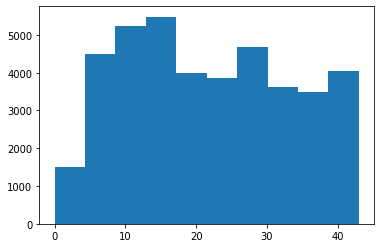

In [7]:
len_seqs = [ e.count("|") for e in X_train_raw]

import matplotlib.pyplot as plt
plt.hist(len_seqs);

In [8]:
import numpy as np
print(np.mean(len_seqs))
print(np.median(len_seqs))

21.81441410215147
21.0


# 1. Data class

In [7]:
import tensorflow as tf

class SeqData:
    def __init__(self, X, Y, maxlen = maxlen):
        self.X = X 
        self.Y = Y
        self.maxlen = maxlen
        self.inp_tokenizer = tf.keras.preprocessing.text.Tokenizer(
                            filters='',
                            lower=False,
                            split='|',
                            char_level=False,
                            oov_token='<OOV>'
                        )
        self.tag_tokenizer = tf.keras.preprocessing.text.Tokenizer(
                            filters='',
                            lower=False,
                            oov_token='<OOV>'
                        )
        self.inp_tokenizer.fit_on_texts(X)
        self.tag_tokenizer.fit_on_texts(Y)
        self.tag_tokenizer.fit_on_texts(["<BOS>"])
    
    def padding(self, seqs, dtype='int32', value=0.0):
        return tf.keras.preprocessing.sequence.pad_sequences(seqs, padding='post', truncating='post', maxlen=self.maxlen, dtype=dtype, value=value)


    def get_bool_mask(self, seqs):
        mask = [
                [True for _ in seq] for seq in seqs
            ]
        return self.padding(mask, dtype=bool, value=False)

    def preprocess(self, X, Y):
        tokens = self.inp_tokenizer.texts_to_sequences(X)
        tags   = self.tag_tokenizer.texts_to_sequences(Y)

        tokens_pad =  self.padding(tokens)
        tags_pad   =  self.padding(tags)

        return tokens_pad, tags_pad

    def load_dataset(self, X, Y, BATCH_SIZE=64):

        # create boolean mask
        bool_mask = self.get_bool_mask(Y)

        # preprocess X
        tokens, targets = self.preprocess(X, Y)

        # create dataset
        if BATCH_SIZE:
            dataset = tf.data.Dataset.from_tensor_slices((tokens, targets, bool_mask))\
                        .shuffle(1000)\
                        .batch(BATCH_SIZE, drop_remainder=True)
        else:
            dataset = tf.data.Dataset.from_tensor_slices((tokens, targets, bool_mask))\
                        .shuffle(1000)\
                        .batch(len(X_dev_raw), drop_remainder=True)


        return dataset, bool_mask, self.inp_tokenizer, self.tag_tokenizer

In [8]:
data_creator = SeqData(X_train_raw, Y_train_raw)

train_dataset, train_bool_mask, inp_tokenizer, tag_tokenizer = data_creator.load_dataset(X_train_raw, Y_train_raw)
dev_dataset, dev_bool_mask, _, _ = data_creator.load_dataset(X_dev_raw, Y_dev_raw, BATCH_SIZE=None)

In [9]:
example_X_batch, example_Y_batch, example_mask = next(iter(train_dataset))
print(example_X_batch.shape, example_Y_batch.shape, example_mask.shape)

(64, 45) (64, 45) (64, 45)


In [10]:
example_X_batch

<tf.Tensor: shape=(64, 45), dtype=int32, numpy=
array([[ 576,    2,    7, ...,    0,    0,    0],
       [   5,   35,   13, ...,    0,    0,    0],
       [   4,   10, 1020, ...,    0,    0,    0],
       ...,
       [  35,    3, 2045, ...,    0,    0,    0],
       [ 208, 2334,  475, ...,    0,    0,    0],
       [ 216,    2,  531, ...,    0,    0,    0]], dtype=int32)>

In [11]:
example_Y_batch

<tf.Tensor: shape=(64, 45), dtype=int32, numpy=
array([[ 2,  2,  2, ...,  0,  0,  0],
       [ 2,  2,  2, ...,  0,  0,  0],
       [ 2,  2,  2, ...,  0,  0,  0],
       ...,
       [ 2,  2,  9, ...,  0,  0,  0],
       [ 2,  4,  2, ...,  0,  0,  0],
       [ 2,  2, 13, ...,  0,  0,  0]], dtype=int32)>

In [12]:
example_mask

<tf.Tensor: shape=(64, 45), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

# 2. params

In [13]:
vocab_inp_size = len(inp_tokenizer.word_index)+1
vocab_tar_size = len(tag_tokenizer.word_index)+1
max_length_input = example_X_batch.shape[1]
max_length_output = example_Y_batch.shape[1]


embedding_dim = 70
enc_units = dec_units = 64
enc_num_rnn_layers = dec_num_rnn_layers = 3

# 3. Encoder

In [14]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, num_layers, dropout=0):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

        self.gru_layer = tf.keras.layers.RNN(
            tf.keras.layers.StackedRNNCells([
                tf.keras.layers.GRUCell(units = enc_units, dropout = dropout) 
                for _ in range(num_layers)
            ]),
            name = 'Encoder_RNN',
            return_sequences = True,
            return_state = True
        )

    def call(self, x, **kwr):
        x = self.embedding(x)
        output, *h = self.gru_layer(x, **kwr)
        return output, h

In [10]:
## Test Encoder Stack
encoder = Encoder(vocab_inp_size, embedding_dim, enc_units, enc_num_rnn_layers)

# sample input
sample_output, sample_h = encoder(example_X_batch)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder {} h vectors shape, each with shape: (batch size, units) {}'.format(enc_num_rnn_layers, sample_h[0].shape ))

Encoder output shape: (batch size, sequence length, units) (64, 45, 64)
Encoder 3 h vectors shape, each with shape: (batch size, units) (64, 64)


In [11]:
sample_output.shape

TensorShape([64, 45, 64])

# 4. Decoder

In [15]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, num_layers, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.embed = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)
        self.rnn   = tf.keras.layers.RNN(
            tf.keras.layers.StackedRNNCells([
                tf.keras.layers.GRUCell(units = dec_units, dropout = dropout) 
                for _ in range(num_layers)
            ]),
            name = 'Decoder_RNN',
            return_sequences = True,
            return_state = True
        )
        self.dense = tf.keras.layers.Dense(units = vocab_size)
        
    def init_state(self, enc_states):
        return enc_states

    def get_context(self, enc_output_sequences, X_shape):
        context = enc_output_sequences[:,-1,:]
        context_for_all_timestep = tf.repeat(tf.expand_dims(context, axis=1), repeats=X_shape[1], axis=1)
        return context_for_all_timestep

        
    def call(self, X, enc_output_sequences, state, **kwargs):  ## X : (batch_size, max_steps) and state : (1, num_encRnn_hiddens)
        
        X = self.embed(X)  ## X : (batch_size, max_steps, emb_size)
        ## construct Decoder input : (batch_size, max_steps, emb_size + last_state.shape[1])
        context = self.get_context(enc_output_sequences, X.shape)
        dec_input = tf.concat([X, context], axis=2)
        
        ## Forward pass: pass hidden state from rnn to Dense
        rnn_output, *h = self.rnn(inputs=dec_input, initial_state=state)
        
        output = self.dense(rnn_output)   ## output : (batch_size, vocab_size)
        
        return output, h

# 5. Model wrapper

In [28]:
class Seq2Seq(tf.keras.Model):
    def __init__(self, encoder, decoder, tag_tokenizer, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.tag_tokenizer = tag_tokenizer
    
    def call(self, enc_inp, dec_inp, **kwargs):
        enc_sequences, enc_states = self.encoder(enc_inp, **kwargs)
        dec_init_state = self.decoder.init_state(enc_states)
        
        return self.decoder(dec_inp, enc_sequences, dec_init_state, **kwargs)

In [14]:
encoder = Encoder(vocab_inp_size, embedding_dim, enc_units, enc_num_rnn_layers)
decoder = Decoder(vocab_tar_size, embedding_dim, dec_units, dec_num_rnn_layers)

enc_sequences, enc_states = encoder(example_X_batch)

dec_init_state = decoder.init_state(enc_states)
output, dec_state = decoder(example_Y_batch, enc_sequences, dec_init_state)

In [15]:
output.shape, len(dec_state), dec_state[0].shape
# next iter: output, dec_state = decoder(example_Y_batch, enc_sequences, dec_state)

(TensorShape([64, 45, 26]), 3, TensorShape([64, 64]))

# 6. Loss function

In [16]:
class MaskedSoftmaxCELoss(tf.keras.losses.Loss):
    """The softmax cross-entropy loss with masks."""
    def __init__(self, bool_mask):
        super().__init__(reduction='none')
        self.bool_mask = tf.cast(bool_mask, tf.float32)

    def mask_O_token(self, label):
        O_index = tag_tokenizer.word_index["O"]
        return tf.cast(tf.where(label == O_index, False, True), tf.float32)

    def call(self, label, pred):
        #O_masked = self.mask_O_token(label)

        label_one_hot = tf.one_hot(label, depth=pred.shape[-1])
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy(
            from_logits=True, reduction='none')(label_one_hot, pred)
        
        weighted_loss = tf.reduce_mean((unweighted_loss*self.bool_mask), axis=1)
        return weighted_loss

In [61]:
loss = MaskedSoftmaxCELoss(tf.constant([[True, True, False, False], [True, True, True, True], [False, False, False, False]]))
test_label = tf.ones((3,4), dtype = tf.int32)
test_pred = tf.ones((3, 4, 10))
loss(test_label, test_pred).numpy()

array([1.1512926, 2.3025851, 0.       ], dtype=float32)

# 7. Train step

In [17]:
import numpy as np
# example_X_batch, example_Y_batch, example_mask = next(iter(train_dataset))

def train(encoder, decoder, dataset, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    history = []
    for epoch in range(num_epochs):
        
        losses = []
        for i, (X, Y, mask) in enumerate(dataset):
            ## X : (batch_size, maxlen)
            ## Y : (batch_size, maxlen)

            BOS_id = tag_tokenizer.word_index["<BOS>"]
            dec_input = tf.repeat( tf.expand_dims( [BOS_id], 1), X.shape[0], axis=0)
            dec_input = tf.concat([dec_input, Y], axis=1)[:,:-1]

            with tf.GradientTape() as tape:
                enc_seqs, enc_states = encoder(X)

                dec_initial_state = decoder.init_state(enc_states)
                output, dec_state = decoder(dec_input, enc_seqs, dec_initial_state)
                
                l = MaskedSoftmaxCELoss(mask)(Y, output)
                losses.append(tf.reduce_mean(l).numpy())
            
            if i%100 == 0:
                print(f'epoch {epoch} / batch: {i} / loss ', np.array(losses).mean())

            variables = encoder.trainable_variables + decoder.trainable_variables
            gradients = tape.gradient(l, variables)
            optimizer.apply_gradients(zip(gradients, variables))
            

        print(f'epoch {epoch} / loss ', np.array(losses).mean())
        history.append(losses)
    return history

# 8. Train the model

In [38]:
tf.config.list_physical_devices('GPU')

[]

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, enc_units, enc_num_rnn_layers)
decoder = Decoder(vocab_tar_size, embedding_dim, dec_units, dec_num_rnn_layers)

In [ ]:
lr = 0.005
num_epochs = 10
history = train(encoder, decoder, train_dataset, lr, num_epochs)

In [38]:
def inference(X):
    enc_seqs, enc_states = encoder(X)
    dec_state = decoder.init_state(enc_states)

    BOS_id = tag_tokenizer.word_index["<BOS>"]
    dec_input = tf.repeat( tf.expand_dims( [BOS_id], 1), X.shape[0], axis=0)

    for i in range(maxlen):
        Y, dec_state = decoder(dec_input, enc_seqs, dec_state)

        last_step_logit = Y[:,-1,:]
        last_step_maxIndex = tf.expand_dims(tf.argmax(last_step_logit, -1, output_type=tf.int32), axis=1)
        dec_input = tf.concat([dec_input, last_step_maxIndex], axis=1)

    return dec_input.numpy()

Test model's output

In [52]:
i = 851
X_sample, Y_sample = data_creator.preprocess(X_dev_raw[i:i+1], Y_dev_raw[i:i+1])
output = inference(X_sample)

print(Y_dev_raw[i:i+1])
print(tag_tokenizer.sequences_to_texts(output))

[['O', 'O', 'O', 'O', 'B_TTL', 'B_PER', 'I_PER', 'I_PER', 'I_PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_ORG', 'I_ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_DTM', 'I_DTM', 'I_DTM', 'I_DTM', 'I_DTM', 'I_DTM', 'I_DTM', 'I_DTM', 'I_DTM']]
['<BOS> O O B_TTL B_PER I_PER I_PER O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O']


### Save model

In [29]:
# wrap encoder and decoder to a single keras.Model
model = Seq2Seq(encoder, decoder, tag_tokenizer)

# pass data to build a graph
_ = model(example_X_batch, example_Y_batch)

# save model
model.save("/content/model")

In [33]:
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 64%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model/keras_metadata.pb (deflated 92%)
  adding: content/model/saved_model.pb (deflated 91%)


In [53]:
import pickle

# save tokenizers
with open('/content/tag_tokenizer.pkl', 'wb') as outp:
    pickle.dump(tag_tokenizer, outp, pickle.HIGHEST_PROTOCOL)

with open('/content/inp_tokenizer.pkl', 'wb') as outp:
    pickle.dump(inp_tokenizer, outp, pickle.HIGHEST_PROTOCOL)